# Financial Fraud Detection using Decision Tree Machine Learning Models

Here, we will showcase the use of decision tree ML models to perform financial fraud detection.

<br/>

### Source Data
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

<br/>

### Dictionary
This is the column definition of the referenced sythentic dataset.

| Column Name | Description |
| ----------- | ----------- | 
| step | maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).|
| type | CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. |
| amount |  amount of the transaction in local currency. |
| nameOrig | customer who started the transaction |
| oldbalanceOrg | initial balance before the transaction |
| newbalanceOrig | new balance after the transaction |
| nameDest | customer who is the recipient of the transaction |
| oldbalanceDest | initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants). |
| newbalanceDest | new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants). |
<br/>

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Configure MLflow Experiment
mlflow_experiment_id = 866112

# Including MLflow
import mlflow
import mlflow.spark

import os
print("MLflow Version: %s" % mlflow.__version__)

MLflow Version: 0.8.2

In [0]:
# Create df DataFrame which contains our simulated financial fraud detection dataset
df = spark.sql("select step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest from sim_fin_fraud_detection")

In [0]:
# Review the schema of your data 
df.printSchema()

root
-- step: integer (nullable = true)
-- type: string (nullable = true)
-- amount: double (nullable = true)
-- nameOrig: string (nullable = true)
-- oldbalanceOrg: double (nullable = true)
-- newbalanceOrig: double (nullable = true)
-- nameDest: string (nullable = true)
-- oldbalanceDest: double (nullable = true)
-- newbalanceDest: double (nullable = true)

### Calculate Differences between Originating and Destination Balanaces
With the following PySpark DataFrame query, we will calculate the following columns:

| New Column | Definition |
| ---------- | ---------- |
| orgDiff | Difference between the originating balance |
| destDiff | Difference between the destination balance |

In [0]:
# Calculate the differences between originating and destination balances
df = df.withColumn("orgDiff", df.newbalanceOrig - df.oldbalanceOrg).withColumn("destDiff", df.newbalanceDest - df.oldbalanceDest)

# Create temporary view
df.createOrReplaceTempView("financials")

#### What are the type of transactions?

In [0]:
%sql
-- Organize by Type
select type, count(1) from financials group by type

type,count(1)
TRANSFER,532909
CASH_IN,1399284
CASH_OUT,2237500
PAYMENT,2151495
DEBIT,41432


#### How much money are we talking about (synthetically)?

In [0]:
%sql
select type, sum(amount) from financials group by type

type,sum(amount)
TRANSFER,4.852919872631695E11
CASH_IN,2.3636739191246045E11
CASH_OUT,3.9441299522449023E11
PAYMENT,2.809337113837001E10
DEBIT,2.2719922127999982E8


## Rules-based Model: Create a set of rules to identify fraud based on known cases

The following `where` clause are a set of rules to identify know fraud-based cases using SQL; i.e. rules-based model.
* Often, financial fraud analytics start with with clauses like the `where` clause below
* Note, in reality, rules are often much larger and more complicated

In [0]:
from pyspark.sql import functions as F

# Rules to Identify Known Fraud-based
df = df.withColumn("label", 
                   F.when(
                     (
                       (df.oldbalanceOrg <= 56900) & (df.type == "TRANSFER") & (df.newbalanceDest <= 105)) | 
                       (
                         (df.oldbalanceOrg > 56900) & (df.newbalanceOrig <= 12)) | 
                           (
                             (df.oldbalanceOrg > 56900) & (df.newbalanceOrig > 12) & (df.amount > 1160000)
                           ), 1
                   ).otherwise(0))

# Calculate proportions
fraud_cases = df.filter(df.label == 1).count()
total_cases = df.count()
fraud_pct = 1.*fraud_cases/total_cases

# Provide quick statistics
print("Based on these rules, we have flagged %s (%s) fraud cases out of a total of %s cases." % (fraud_cases, fraud_pct, total_cases))

# Create temporary view to review data
df.createOrReplaceTempView("financials_labeled")

Based on these rules, we have flagged 255640 (0.04017841706718302) fraud cases out of a total of 6362620 cases.

### How much fraud are we talking about?
Based on the existing rules, while 4% of the transactions are fraudulent, it takes into account of the 11% of the total amount.

In [0]:
%sql
select label, count(1) as `Transactions`, sum(amount) as `Total Amount` from financials_labeled group by label

label,Transactions,Total Amount
1,255640,1.2932429667647998E11
0,6106980,1.0150686480832826E12


#### Top Origination / Destination Difference Pairs (>$1M TotalDestDiff)
Each bar represents a pair of entities performing a transaction

In [0]:
%sql
-- where sum(destDiff) >= 10000000.00
select nameOrig, nameDest, label, TotalOrgDiff, TotalDestDiff
  from (
     select nameOrig, nameDest, label, sum(OrgDiff) as TotalOrgDiff, sum(destDiff) as TotalDestDiff 
       from financials_labeled 
      group by nameOrig, nameDest, label 
     ) a
 where TotalDestDiff >= 1000000
 limit 100

nameOrig,nameDest,label,TotalOrgDiff,TotalDestDiff
C752686443,C1816757085,0,-51178.0,1037297.459999999
C1034899044,C306206744,0,0.0,2308448.1800000006
C1337803451,C1778801068,0,0.0,3155647.91
C1570013189,C1945802665,1,-63916.0,1179067.2799999998
C1379731404,C413177525,0,0.0,2375262.37
C608080514,C2006081398,1,-101396.29,3208776.46
C1567963311,C1141049797,0,136177.75999999978,1243657.54
C582291919,C461640598,0,0.0,3381134.63
C689413511,C1988852187,0,0.0,1161908.05
C122861681,C1754722089,0,-22291.0,1512938.6399999997


### What type of transactions are associated with fraud?
Reviewing the rules-based model, it appears that most fraudulent transactions are in the category of `Transfer` and `Cash_Out`.

In [0]:
%sql
select type, label, count(1) as `Transactions` from financials_labeled group by type, label

type,label,Transactions
PAYMENT,0,2150909
CASH_OUT,0,2052790
DEBIT,1,31
TRANSFER,1,70248
CASH_OUT,1,184710
PAYMENT,1,586
DEBIT,0,41401
CASH_IN,0,1399219
TRANSFER,0,462661
CASH_IN,1,65


### Create training and test datasets
To build and validate our generalized fraud ML model, we will initially split the data using `randomSplit` to create our training and test datasets.

In [0]:
# Initially split our dataset between training and test datasets
(train, test) = df.randomSplit([0.8, 0.2], seed=12345)

# Cache the training and test datasets
train.cache()
test.cache()

# Print out dataset counts
print("Total rows: %s, Training rows: %s, Test rows: %s" % (df.count(), train.count(), test.count()))

Total rows: 6362620, Training rows: 5090394, Test rows: 1272226

### Create ML Pipeline
When creating an ML model, there are typically a set of repeated steps (e.g. `StringIndexer`, `VectorAssembler`, etc.).  By creating a ML pipeline, we can reuse this pipeline (and all of its steps) to retrain on a new and/or updated dataset.

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

# Encodes a string column of labels to a column of label indices
indexer = StringIndexer(inputCol = "type", outputCol = "typeIndexed")

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
va = VectorAssembler(inputCols = ["typeIndexed", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "orgDiff", "destDiff"], outputCol = "features")

# Using the DecisionTree classifier model
dt = DecisionTreeClassifier(labelCol = "label", featuresCol = "features", seed = 54321, maxDepth = 5)

# Create our pipeline stages
pipeline = Pipeline(stages=[indexer, va, dt])

In [0]:
# View the Decision Tree model (prior to CrossValidator)
dt_model = pipeline.fit(train)
display(dt_model.stages[-1])

treeNode
"{""index"":13,""featureType"":""continuous"",""prediction"":null,""threshold"":-59767.5,""categories"":null,""feature"":6,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":17.18,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":8142508.215,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":671642.935,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":2296867.575,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":671642.935,""categories"":null,""feature"":1,""overflow"":false}"


### Use BinaryClassificationEvaluator
Determine the accuracy of the model by reviewing the `areaUnderPR` and `areaUnderROC`

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use BinaryClassificationEvaluator to evaluate our model
evaluatorPR = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = "prediction", metricName = "areaUnderPR")
evaluatorAUC = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = "prediction", metricName = "areaUnderROC")

### Setup CrossValidation
To try out different parameters to potentially improve our model, we will use `CrossValidator` in conjunction with the `ParamGridBuilder` to automate trying out different parameters.

Note, we are using `evaluatorPR` as our `evaluator` as the Precision-Recall curve is often better for an unbalanced distribution.

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Build the grid of different parameters
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .build()

# Build out the cross validation
crossval = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorPR,
                          numFolds = 3)  

pipelineCV = Pipeline(stages=[indexer, va, crossval])

# Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
cvModel_u = pipelineCV.fit(train)

### Review Results
Review the `areaUnderPR` (area under Precision Recall curve) and `areaUnderROC` (area under Receiver operating characteristic) or `AUC` (area under curve) metrics.

In [0]:
# Build the best model (training and test datasets)
train_pred = cvModel_u.transform(train)
test_pred = cvModel_u.transform(test)

# Evaluate the model on training datasets
pr_train = evaluatorPR.evaluate(train_pred)
auc_train = evaluatorAUC.evaluate(train_pred)

# Evaluate the model on test datasets
pr_test = evaluatorPR.evaluate(test_pred)
auc_test = evaluatorAUC.evaluate(test_pred)

# Print out the PR and AUC values
print("PR train:", pr_train)
print("AUC train:", auc_train)
print("PR test:", pr_test)
print("AUC test:", auc_test)

PR train: 0.9537894984523128
AUC train: 0.998647996459481
PR test: 0.9539170535377599
AUC test: 0.9984378183482442

### Confusion Matrix Code-base
Subsequent cells will be using the following code to plot the confusion matrix.

In [0]:
# Create confusion matrix template
from pyspark.sql.functions import lit, expr, col, column

# Confusion matrix template
cmt = spark.createDataFrame([(1, 0), (0, 0), (1, 1), (0, 1)], ["label", "prediction"])
cmt.createOrReplaceTempView("cmt")

In [0]:
# Source code for plotting confusion matrix is based on `plot_confusion_matrix` 
# via https://runawayhorse001.github.io/LearningApacheSpark/classification.html#decision-tree-classification
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, title):
  # Clear Plot
  plt.gcf().clear()

  # Configure figure
  fig = plt.figure(1)
  
  # Configure plot
  classes = ['Fraud', 'No Fraud']
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  # Normalize and establish threshold
  normalize=False
  fmt = 'd'
  thresh = cm.max() / 2.

  # Iterate through the confusion matrix cells
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  # Final plot configurations
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label') 
  
  # Display images
  image = fig
  
  # Show plot
  #fig = plt.show()
  
  # Save plot
  fig.savefig("confusion-matrix.png")

  # Display Plot
  display(image)
  
  # Close Plot
  plt.close(fig)

In [0]:
# Create temporary view for test predictions
test_pred.createOrReplaceTempView("test_pred")

# Create test predictions confusion matrix
test_pred_cmdf = spark.sql("select a.label, a.prediction, coalesce(b.count, 0) as count from cmt a left outer join (select label, prediction, count(1) as count from test_pred group by label, prediction) b on b.label = a.label and b.prediction = a.prediction order by a.label desc, a.prediction desc")

# View confusion matrix
display(test_pred_cmdf)

label,prediction,count
1,1,50717
1,0,58
0,1,2421
0,0,1219030


### View Confusion Matrix
Let's use `matplotlib` and `pandas` to visualize our confusion matrix

In [0]:
# Convert to pandas
cm_pdf = test_pred_cmdf.toPandas()

# Create 1d numpy array of confusion matrix values
cm_1d = cm_pdf.iloc[:, 2]

# Create 2d numpy array of confusion matrix values
cm = np.reshape(cm_1d, (-1, 2))

# Print out the 2d array
print(cm)

[[ 50717 58]
 [ 2421 1219030]]

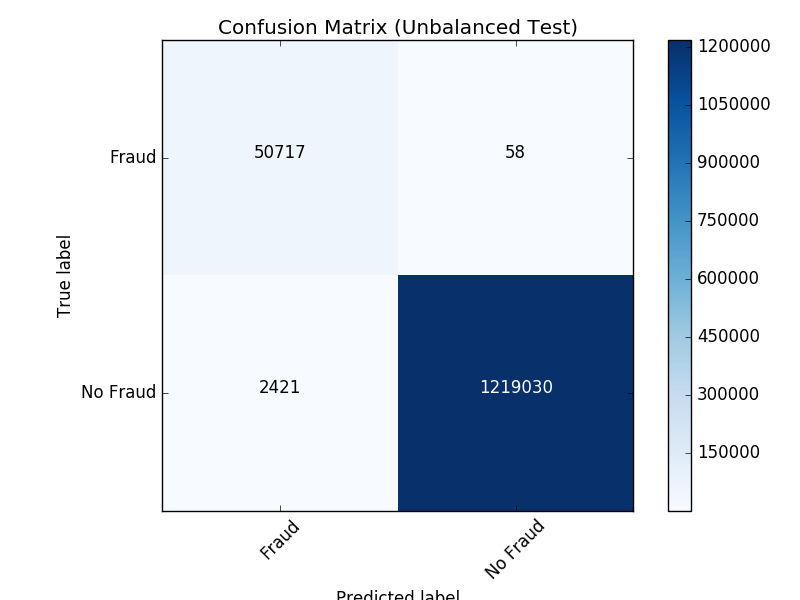

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm, "Confusion Matrix (Unbalanced Test)")

In [0]:
# Log MLflow
with mlflow.start_run(experiment_id = mlflow_experiment_id) as run:
  # Log Parameters and metrics
  mlflow.log_param("balanced", "no")
  mlflow.log_metric("PR train", pr_train)
  mlflow.log_metric("AUC train", auc_train)
  mlflow.log_metric("PR test", pr_test)
  mlflow.log_metric("AUC test", auc_test)
  
  # Log model
  mlflow.spark.log_model(dt_model, "model")
  
  # Log Confusion matrix
  mlflow.log_artifact("confusion-matrix.png")

## Model with Balanced classes

Let's see if we can improve our decision tree model but balancing the Fraud vs. No Fraud cases. We will tune the model using the metrics `areaUnderROC` or (AUC)

In [0]:
# Reset the DataFrames for no fraud (`dfn`) and fraud (`dfy`)
dfn = train.filter(train.label == 0)
dfy = train.filter(train.label == 1)

# Calculate summary metrics
N = train.count()
y = dfy.count()
p = y/N

# Create a more balanced training dataset
train_b = dfn.sample(False, p, seed = 92285).union(dfy)

# Print out metrics
print("Total count: %s, Fraud cases count: %s, Proportion of fraud cases: %s" % (N, y, p))
print("Balanced training dataset count: %s" % train_b.count())

Total count: 5090394, Fraud cases count: 204865, Proportion of fraud cases: 0.040245411258932016
Balanced training dataset count: 401898

In [0]:
# Display our more balanced training dataset
display(train_b.groupBy("label").count())

label,count
1,204865
0,197033


### Update ML pipeline
Because we had created the ML pipeline stages in the previous cells, we can re-use them to execute it against our balanced dataset.

Note, we are using `evaluatorAUC` as our `evaluator` as this is often better for a balanced distribution.

In [0]:
# Re-run the same ML pipeline (including parameters grid)
crossval_b = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorAUC,
                          numFolds = 3)  

pipelineCV_b = Pipeline(stages=[indexer, va, crossval_b])

# Train the model using the pipeline, parameter grid, and BinaryClassificationEvaluator using the `train_b` dataset
cvModel_b = pipelineCV_b.fit(train_b)

In [0]:
# Build the best model (balanced training and full test datasets)
train_pred_b = cvModel_b.transform(train_b)
test_pred_b = cvModel_b.transform(test)

# Evaluate the model on the balanced training datasets
pr_train_b = evaluatorPR.evaluate(train_pred_b)
auc_train_b = evaluatorAUC.evaluate(train_pred_b)

# Evaluate the model on full test datasets
pr_test_b = evaluatorPR.evaluate(test_pred_b)
auc_test_b = evaluatorAUC.evaluate(test_pred_b)

# Print out the PR and AUC values
print("PR train:", pr_train_b)
print("AUC train:", auc_train_b)
print("PR test:", pr_test_b)
print("AUC test:", auc_test_b)

PR train: 0.999629161563572
AUC train: 0.9998071389056655
PR test: 0.9904709171789063
AUC test: 0.9997903902204509

In [0]:
# Create temporary view for test predictions
test_pred_b.createOrReplaceTempView("test_pred_b")

# Create test predictions confusion matrix
test_pred_b_cmdf = spark.sql("select a.label, a.prediction, coalesce(b.count, 0) as count from cmt a left outer join (select label, prediction, count(1) as count from test_pred_b group by label, prediction) b on b.label = a.label and b.prediction = a.prediction order by a.label desc, a.prediction desc")

# View confusion matrix
display(test_pred_b_cmdf)

label,prediction,count
1,1,50774
1,0,1
0,1,488
0,0,1220963


In [0]:
# Convert to pandas
cm_b_pdf = test_pred_b_cmdf.toPandas()

# Create 1d numpy array of confusion matrix values
cm_b_1d = cm_b_pdf.iloc[:, 2]

# Create 2d numpy array of confusion matrix vlaues
cm_b = np.reshape(cm_b_1d, (-1, 2))

# Print out the 2d array
print(cm_b)

[[ 50774 1]
 [ 488 1220963]]

## View Decision Tree Models
Visually compare the differences between the **unbalanced** and **balanced** decision tree models (basd on the `train` and `train_b` datasets respectively).

In [0]:
# Extract Feature Importance
#  Attribution: Feature Selection Using Feature Importance Score - Creating a PySpark Estimator
#               https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
import pandas as pd

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
# View the Unbalanced Decision Tree model (prior to CrossValidator)
dt_model = pipeline.fit(train)
display(dt_model.stages[-1])

treeNode
"{""index"":13,""featureType"":""continuous"",""prediction"":null,""threshold"":-59767.5,""categories"":null,""feature"":6,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":17.18,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":8142508.215,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":671642.935,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":2296867.575,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":671642.935,""categories"":null,""feature"":1,""overflow"":false}"


In [0]:
# Extract Feature Importance for the original unbalanced dt_model
ExtractFeatureImp(dt_model.stages[-1].featureImportances, train_pred, "features").head(10)

Out[ 47 ]: 
 idx name vals \
6 6 orgDiff NaN 
3 3 newbalanceOrig NaN 
5 5 newbalanceDest NaN 
2 2 oldbalanceOrg NaN 
0 0 typeIndexed [CASH_OUT, PAYMENT, CASH_IN, TRANSFER, DEBIT] 
1 1 amount NaN 
4 4 oldbalanceDest NaN 
7 7 destDiff NaN 

 score 
6 0.609449 
3 0.382837 
5 0.005051 
2 0.001903 
0 0.000621 
1 0.000128 
4 0.000010 
7 0.000000

In [0]:
# View the Balanced Decision Tree model (prior to CrossValidator)
dt_model_b = pipeline.fit(train_b)
display(dt_model_b.stages[-1])

treeNode
"{""index"":15,""featureType"":""continuous"",""prediction"":null,""threshold"":-39863.59500000001,""categories"":null,""feature"":6,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":6.26,""categories"":null,""feature"":3,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":51488.5,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":201.245,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":1,""featureType"":""categorical"",""prediction"":null,""threshold"":null,""categories"":[0.0,2.0],""feature"":0,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":13,""featureType"":""continuous"",""prediction"":null,""threshold"":914660.585,""categories"":null,""feature"":1,""overflow"":false}"


In [0]:
# Extract Feature Importance for the nbalanced dt_model
ExtractFeatureImp(dt_model_b.stages[-1].featureImportances, train_pred_b, "features").head(10)

Out[ 49 ]: 
 idx name vals \
6 6 orgDiff NaN 
3 3 newbalanceOrig NaN 
2 2 oldbalanceOrg NaN 
5 5 newbalanceDest NaN 
1 1 amount NaN 
0 0 typeIndexed [CASH_OUT, TRANSFER, PAYMENT, CASH_IN, DEBIT] 
4 4 oldbalanceDest NaN 
7 7 destDiff NaN 

 score 
6 0.901013 
3 0.057844 
2 0.027848 
5 0.010055 
1 0.002049 
0 0.001190 
4 0.000000 
7 0.000000

## Comparing Confusion Matrices
Below we will compare the unbalanced and balanced decision tree ML model confusion matrices.

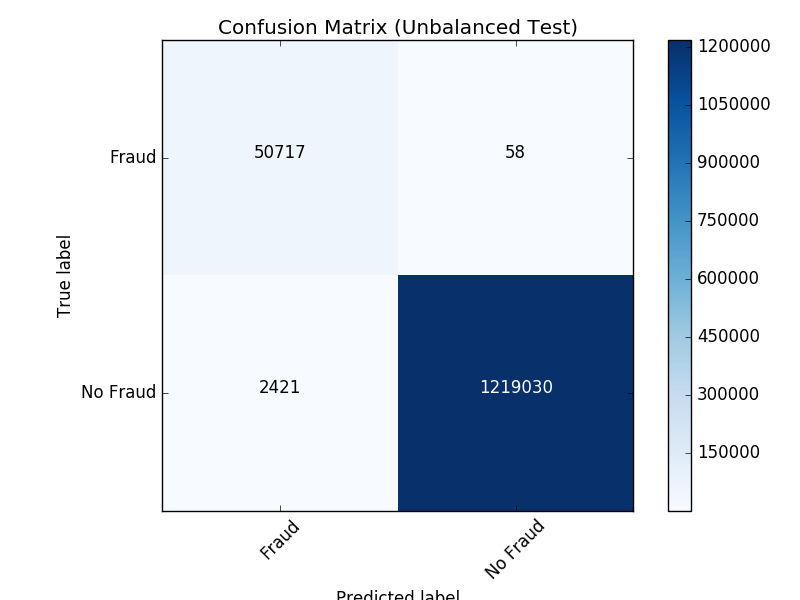

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm, "Confusion Matrix (Unbalanced Test)")

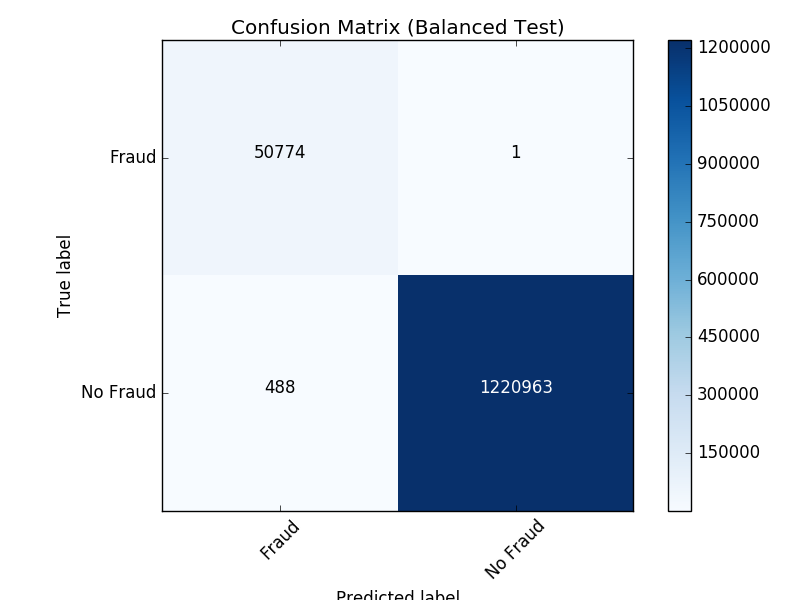

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm_b, "Confusion Matrix (Balanced Test)")

### Observation

There is a significant difference for the `PR` and `AUC` values when comparing the unbalanced vs. balanced decision tree models.

| Metric/dataset | Unbalanced | Balanced |
| -------------- | ---------- | -------- |
| PR train | 0.9537894984523128 | 0.999629161563572 |
| AUC train | 0.998647996459481 | 0.9998071389056655 |
| PR test | 0.9539170535377599 | 0.9904709171789063 |
| AUC test | 0.9984378183482442 | 0.9997903902204509 |